# Item Storage Prediction Model

Module: IT3100

By: Samuel Lee (233221B)

### The Problem:

ANS Import & Export experiences many issues with item mismanagement and retreival in storage, with samples often being lost. To address this issue, the goal of this model is to predict the location where each item should be stored in the warehouse, based on the item's quantity, priority, type, weight, and size.

### The Goal:

Create a supervised model that can determine the storage location of a sample, based on its input data.

## Data Collection

### Initial Dataset

Dataset Link: https://www.kaggle.com/datasets/yusufdelikkaya/online-sales-dataset

Before settling on the final dataset used for this model, a separate dataset containing information on online sales was experimented with.

#### Dataset Features:
- InvoiceNo
- StockCode
- Description
- Quantity
- InvoiceDate
- UnitPrice
- CustomerID
- Country
- Discount
- PaymentMethod
- ShippingCost
- Category
- SalesChannel
- ReturnStatus
- ShipmentProvider
- WarehouseLocation
- OrderPriority

#### Why use this dataset?

Initially, this dataset was used as it aligned well with the problem statement, containing detailed information on various products, their categories, descriptions, and warehouse locations. Additionally, the dataset page contained detailed documentation on the source of the data, its uses, and the different features in the dataset. After attempting to use the data to train a model however, the data was found to insufficient in determining the warehouse location, with the model accuracy plateauing at ~20% each time training was performed.

### The Final Dataset

Dataset: https://www.kaggle.com/datasets/metztl1/warehouse-dataset-2023 

This is the final dataset that was settled on to be used to train the model, following unsuccessful training with the previously used dataset.

#### Dataset Features:
- Order_ID
- Product_ID
- Order_Quantity
- Priority
- Product_Type
- Location
- Weight
- Size

#### Why use this dataset?

Compared to the previous dataset used, the current dataset contains information much more relevant to the model task, with more ordinal data such as item priority, weight, size, and quantity. The current dataset also closely aligns with the problem statement, with data on items stored in the warehouse, and the section of the warehouse each item is stored in (E.g. A-5, B-2, C-6, etc...), which is crucial for classification. Finally, the dataset contains a suitable number of entries for training, with 1500 entries contained in the dataset.

## Importing the Libraries

First, we import the necessary libraries to be used for the data preparation and the model

In [1]:
import os
import tensorflow as tf
from tensorflow import keras as keras
import keras.layers as layers
from keras.applications import vgg16
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import requests, io, zipfile
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Reading the dataset

The warehouse dataset is downloaded and stored in the project folder as a .csv file. Here, we read the file using pandas, storing it as "df".

In [2]:
df = pd.read_csv("Updated Warehouse Data.csv")
df

Order_ID Product_ID  Order_Quantity Priority Product_Type Location  \
0        10111       P001               9     High       Sports      A-5   
1        10112       P002              13     High  Electronics      A-5   
2        10113       P003              16      Low     Clothing      B-2   
3        10114       P004               5     High   Home Goods      C-1   
4        10115       P005               5      Low  Electronics      A-6   
...        ...        ...             ...      ...          ...      ...   
1495      1042       P042               9   Medium       Sports      C-3   
1496      1038       P038              24   Medium       Sports      B-5   
1497      1028       P028              20   Medium  Electronics      C-2   
1498      1022       P022              19     High       Sports      B-3   
1499      1030       P030              11      Low     Clothing      A-4   

      Weight    Size  
0       9.78   Small  
1       5.42  Medium  
2       7.51   Large  
3       8.39   Small  
4       7.47   Large  
...      ...     ...  
1495    4.41   Small  
1496    4.68   Small  
1497    1.79   Small  
1498    4.32   Small  
1499    1.02  Medium  

[1500 rows x 8 columns]

## Data Visualization

#### Number of items per storage section

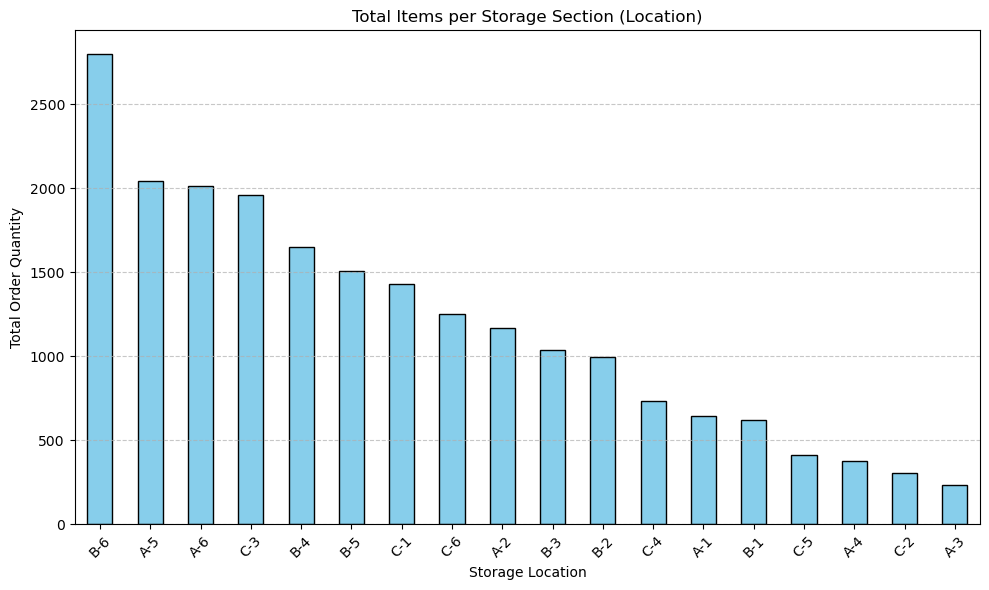

In [3]:
items_per_location = df.groupby('Location')['Order_Quantity'].sum()

# Sort the result
items_per_location = items_per_location.sort_values(ascending=False)

# Plot using matplotlib
plt.figure(figsize=(10, 6))
items_per_location.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Items per Storage Section (Location)')
plt.xlabel('Storage Location')
plt.ylabel('Total Order Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### Heatmap

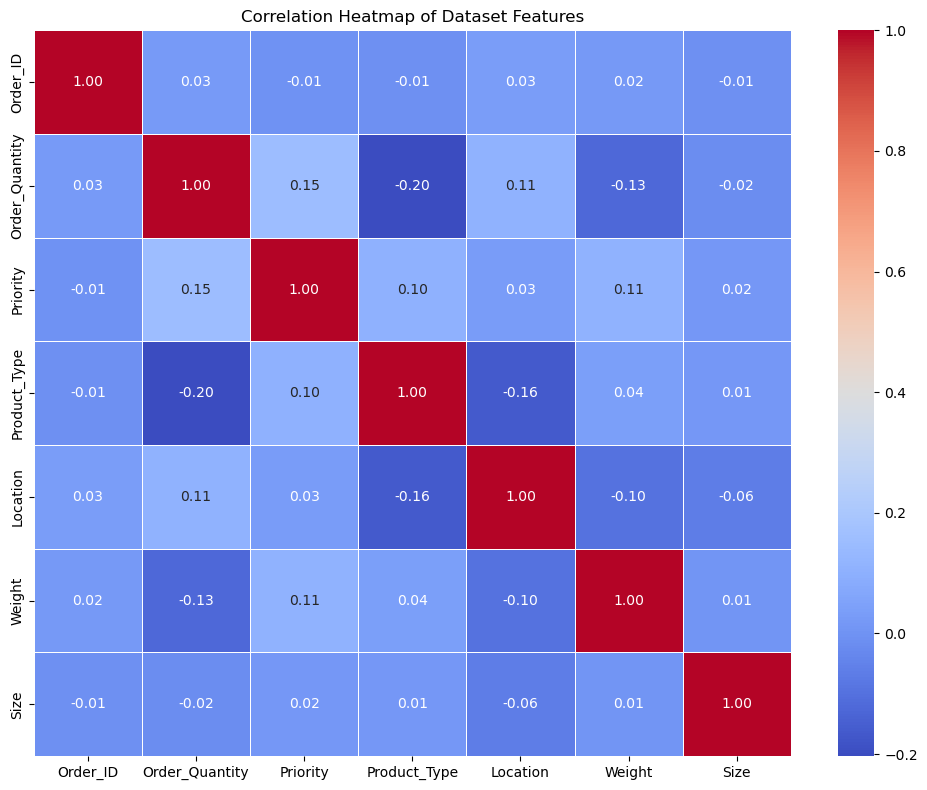

In [4]:
# Encode categorical features
df_encoded = df.copy()
categorical_cols = ['Priority', 'Product_Type', 'Location', 'Size']

# Convert categorical columns to category codes
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Compute correlation matrix
corr_matrix = df_encoded.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of Dataset Features')
plt.tight_layout()
plt.show()

## Data Preparation

#### Dropping unnecessary features

Here, we drop the features in the dataset that are unecessary in training the model. As the Order_ID and Product_ID contain only unique values, with no correlation with the other features in the dataset, we drop them to help reduce the number of features input into the model for training. This also helps to prevent overfitting as the model could otherwise end up relying on the IDs in the training data for making predictions, making it less reliable when making predictions for unseen data.

In [5]:
df1 = df
df1 = df1.drop(['Order_ID','Product_ID'],axis=1)
df1

Order_Quantity Priority Product_Type Location  Weight    Size
0                  9     High       Sports      A-5    9.78   Small
1                 13     High  Electronics      A-5    5.42  Medium
2                 16      Low     Clothing      B-2    7.51   Large
3                  5     High   Home Goods      C-1    8.39   Small
4                  5      Low  Electronics      A-6    7.47   Large
...              ...      ...          ...      ...     ...     ...
1495               9   Medium       Sports      C-3    4.41   Small
1496              24   Medium       Sports      B-5    4.68   Small
1497              20   Medium  Electronics      C-2    1.79   Small
1498              19     High       Sports      B-3    4.32   Small
1499              11      Low     Clothing      A-4    1.02  Medium

[1500 rows x 6 columns]

#### Removing any Missing Values

It is common practice in data preparation to drop/replace any null values. Here we run the code used to drop all null values in the dataset.

In [6]:
df2 = df1
df2 = df2.dropna()
df2

Order_Quantity Priority Product_Type Location  Weight    Size
0                  9     High       Sports      A-5    9.78   Small
1                 13     High  Electronics      A-5    5.42  Medium
2                 16      Low     Clothing      B-2    7.51   Large
3                  5     High   Home Goods      C-1    8.39   Small
4                  5      Low  Electronics      A-6    7.47   Large
...              ...      ...          ...      ...     ...     ...
1495               9   Medium       Sports      C-3    4.41   Small
1496              24   Medium       Sports      B-5    4.68   Small
1497              20   Medium  Electronics      C-2    1.79   Small
1498              19     High       Sports      B-3    4.32   Small
1499              11      Low     Clothing      A-4    1.02  Medium

[1500 rows x 6 columns]

Upon running the code, we can see that there were no null values in the dataset to begin with; The number of rows remains unchanged. Regardless, it is still good practice to perform this step.

#### Extracting the values into feature and target

As the goal of the model is to predict the location of storage, we set the Location as the target (y), with the remaining features in the dataset as the features (x)

In [7]:
x = df2.drop(df2.columns[3], axis=1).values
y = df2['Location'].values
print(x)
print(y)
print(f"Labels: {df2['Location'].unique()}")

[[9 'High' 'Sports' 9.78 'Small']
 [13 'High' 'Electronics' 5.42 'Medium']
 [16 'Low' 'Clothing' 7.51 'Large']
 ...
 [20 'Medium' 'Electronics' 1.79 'Small']
 [19 'High' 'Sports' 4.32 'Small']
 [11 'Low' 'Clothing' 1.02 'Medium']]
['A-5' 'A-5' 'B-2' ... 'C-2' 'B-3' 'A-4']
Labels: ['A-5' 'B-2' 'C-1' 'A-6' 'A-3' 'B-1' 'A-2' 'C-2' 'B-6' 'C-3' 'B-4' 'B-3'
 'A-1' 'C-5' 'C-6' 'A-4' 'B-5' 'C-4']


#### Encoding the Categorical Data

At this step, we encode the categorical data into a format readable by the model. We use one-hot encoding to encode the non-numerical features (Priority, Product_Type, and Size), as the model is only able read numerical values, and the use of one-hot encoding helps to prevent any unintended ordering of the data. We also encode the target using LabelEncoder.

In [8]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), [1,2,4])], remainder='passthrough')
x_final = np.array(ct.fit_transform(x))

In [9]:
index = 1497

print(x_final[index])
print(y[index])

[0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 20 1.79]
C-2


#### Splitting the Dataset into Training and Validation sets

Here we split the dataset into 80% training data abd 20% testing data, an optimal ratio for the modelling phase. We also add random_state = 42 to randomize the order of the data, allowing the model training to be more robust.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size = 0.2, random_state = 42)
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)

In [11]:
print(X_train)

[[ 0.    1.    0.   ...  0.   17.    4.52]
 [ 1.    0.    0.   ...  1.   17.    6.39]
 [ 1.    0.    0.   ...  0.   20.    2.25]
 ...
 [ 0.    1.    0.   ...  1.   17.    4.52]
 [ 0.    1.    0.   ...  0.   12.    7.24]
 [ 0.    1.    0.   ...  0.    8.    8.66]]


In [12]:
print(X_test)

[[ 0.    1.    0.   ...  0.   12.    7.24]
 [ 0.    1.    0.   ...  1.    7.    7.37]
 [ 1.    0.    0.   ...  0.   13.    7.67]
 ...
 [ 0.    1.    0.   ...  0.   23.    5.89]
 [ 0.    1.    0.   ...  0.   24.    8.2 ]
 [ 1.    0.    0.   ...  0.    7.    4.41]]


In [13]:
print(y_train)

['C-6' 'B-6' 'A-6' ... 'C-6' 'C-4' 'A-2']


In [14]:
print(y_test)

['C-4' 'B-4' 'C-1' 'B-6' 'A-5' 'C-3' 'A-5' 'B-6' 'A-6' 'B-6' 'B-6' 'C-1'
 'B-3' 'B-6' 'C-3' 'B-6' 'C-2' 'B-1' 'C-1' 'B-5' 'B-4' 'C-1' 'C-1' 'A-6'
 'B-5' 'B-6' 'A-5' 'A-6' 'B-1' 'A-6' 'B-3' 'A-4' 'B-5' 'B-4' 'C-3' 'A-2'
 'C-3' 'A-4' 'B-2' 'C-3' 'B-6' 'B-2' 'A-4' 'A-6' 'C-3' 'A-6' 'A-5' 'B-3'
 'C-4' 'B-6' 'A-5' 'C-1' 'C-2' 'C-6' 'A-5' 'A-2' 'B-4' 'B-4' 'C-3' 'A-5'
 'B-6' 'B-2' 'A-6' 'C-6' 'B-6' 'B-6' 'C-3' 'B-4' 'A-2' 'B-1' 'A-6' 'A-6'
 'A-1' 'C-4' 'B-1' 'A-1' 'A-2' 'B-4' 'B-3' 'B-3' 'B-6' 'A-4' 'C-1' 'A-2'
 'A-4' 'C-6' 'A-1' 'C-6' 'C-1' 'B-2' 'B-6' 'B-1' 'A-4' 'A-2' 'B-6' 'C-6'
 'B-4' 'A-4' 'B-6' 'B-1' 'C-1' 'B-5' 'A-2' 'B-4' 'B-6' 'C-3' 'A-1' 'C-3'
 'B-6' 'B-6' 'C-1' 'B-4' 'A-2' 'A-3' 'C-6' 'C-1' 'B-6' 'C-1' 'B-6' 'B-4'
 'B-6' 'A-6' 'C-3' 'A-5' 'C-5' 'B-1' 'A-2' 'C-6' 'A-2' 'B-1' 'A-4' 'C-5'
 'C-1' 'B-4' 'B-4' 'A-6' 'B-1' 'B-6' 'B-3' 'A-1' 'A-6' 'C-1' 'C-4' 'A-3'
 'B-6' 'A-5' 'B-6' 'B-1' 'B-3' 'C-4' 'C-3' 'A-6' 'B-5' 'B-6' 'C-6' 'A-2'
 'C-6' 'C-3' 'C-4' 'A-3' 'C-1' 'B-5' 'B-5' 'A-2' 'B

# Making the Model

## Random Forest Model

For creating the model, we must first determine what type of model should be used. The goal of the model is to predict the location where each item should be stored in the warehouse, with a code for each section. To determine the location, the model must choose a location based on the features provided in the input, which is a clear case of multi-class classification. Now that we know the nature of the task, there are several types of models available, such as decision trees, random forest, and neural networks, all of which can be used to perform multi-class classification. For this model, we will make use of Random Forest for several reasons:
1. It is more computationally efficient compared to a neural network
2. There is less tuning required compared to a neural network
3. The dataset is on the smaller side, and Random Forest would have a lower risk of overfitting in this case compared to a neural network.
4. The data is structured and tabular, well suited for Random Forest.

Here, we create the random forest model, setting the number of trees created at 100, and adding random_state to randomize the data input into each node. We then train the model, inputting the training data and labels.

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf_model.predict(X_test)

Here, we print the model's accuracy and performance:

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

         A-1       1.00      0.90      0.95        10
         A-2       0.96      1.00      0.98        24
         A-3       1.00      1.00      1.00         5
         A-4       1.00      1.00      1.00        11
         A-5       0.96      0.92      0.94        25
         A-6       1.00      0.92      0.96        25
         B-1       1.00      0.94      0.97        18
         B-2       1.00      0.88      0.93         8
         B-3       0.92      1.00      0.96        11
         B-4       0.95      1.00      0.98        21
         B-5       0.87      1.00      0.93        13
         B-6       1.00      0.98      0.99        41
         C-1       0.97      1.00      0.99        34
         C-2       1.00      1.00      1.00         6
         C-3       0.90      0.90      0.90        21
         C-4       0.88      1.00      0.93         7
         C-5       0.67      0.80      0.7

From the results shown, we can evaluate the model's performance.

Overall performance:
- Accuracy: 0.96 (96%)
    - The model correctly predicted 96% of the labels. This is a very strong result overall.
- Weighted Avg (F1-score: 0.96)
    - This score accounts for the imbalance in class support (number of samples per class) and shows excellent overall model performance.
 
Per-class performance:
- Perfect scores:
    - The classes A-3, A-4, and C-2 all have a precision, recall, and f1-score of 1.00, indicating they were predicted perfectly.
    - These classes likely had clearer patterns that could be easily observed by the model.
- Weaker performance on smaller or harder-to-separate classes:
    - B-2: Recall = 0.88 - 12% of class B-2 instances were missed.
    - B-5: Precision = 0.87 - Out of all the predictions made for class B-5, 87% were predicted correctly, with 13% being false positives.
    - C-4: Precision = 0.88 - Out of all the predictions made for class C-4, 88% were predicted correctly, with 12% being false positives.
    - C-5: Recall = 0.67 - Only 67% of class C-5 instances were caught. Precision = 0.80 - Out of all the predictions made for class C-5, 80% were predicted correctly.

Notably, class C-5 performs much worse in comparison to the other classes, with an f1-score of 0.73. This is significantly lower compared to the average of 0.96.

#### Confusion Matrix

Using the confusion matrix below, we can see the predictions made by the model using the test data. It lets us observe in detail what classes were falsely predicted, or misclassified for other classes.

Text(0.5, 1.0, 'Confusion Matrix')

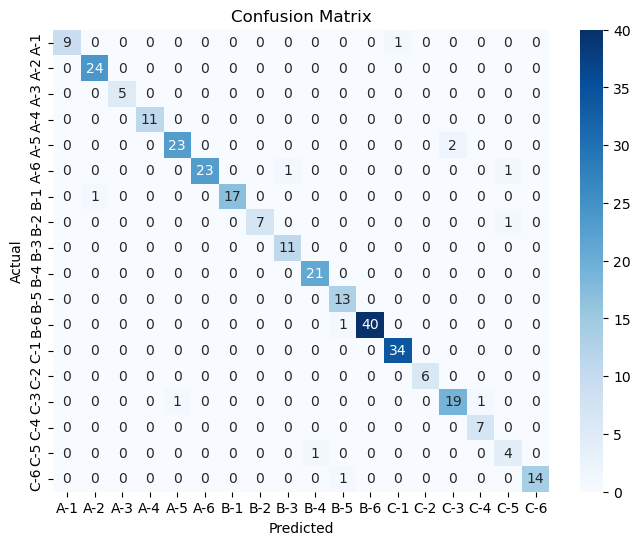

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

### Fine-tuning

#### Finding the best Hyper-parameters using Grid Search

Here we use a grid search to fine-tune the model, searching for the best hyper-parameters to use. This lets us efficiently and automatically tune the model to perform much more effectively, instead of manually editing and testing individual set of hyper-parameters.

In [19]:
from sklearn.model_selection import GridSearchCV

# Grid Search CV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9883


In [20]:
y_pred2 = best_rf.predict(X_test)

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

         A-1       0.91      1.00      0.95        10
         A-2       1.00      1.00      1.00        24
         A-3       1.00      1.00      1.00         5
         A-4       1.00      1.00      1.00        11
         A-5       0.96      1.00      0.98        25
         A-6       1.00      0.96      0.98        25
         B-1       1.00      1.00      1.00        18
         B-2       1.00      1.00      1.00         8
         B-3       0.92      1.00      0.96        11
         B-4       1.00      1.00      1.00        21
         B-5       1.00      1.00      1.00        13
         B-6       1.00      1.00      1.00        41
         C-1       1.00      1.00      1.00        34
         C-2       1.00      1.00      1.00         6
         C-3       1.00      0.95      0.98        21
         C-4       1.00      1.00      1.00         7
         C-5       1.00      0.80      0.8

Evaluating the results for this model:

Overall performance:

Accuracy: 0.99 (99%)
The model correctly predicted 99% of the labels. This is slightly better compared to the previous model, with about a 3% increase in overall accuracy, and reflects a near perfect overall accuracy.

Weighted Avg (F1-score: 0.99)
This score accounts for the imbalance in class support (number of samples per class) and shows a near-perfect overall model performance.

Per-class performance:
Perfect scores:
The classes A-2, A-3, A-4, B-1, B-2, B-4, B-5, B-6, C-1, C-2, C-4, and C-6 all have a precision, recall, and f1-score of 1.00, indicating they were predicted perfectly. Compared to the previous model, there has been quite a leap in performance, predicting 12 classes with perfect accuraccy compared to the original 3. 

Though the accuracy for class C-5 is still lower compared to the average accuracy (0.89), it performs significantly better here, with a 16% increase in accuracy comapred to the previous model.

#### Confusion Matrix

Using the confusion matrix below, we can see the predictions made by the model using the test data. It lets us observe in detail what classes were falsely predicted, or misclassified for other classes.

Text(0.5, 1.0, 'Confusion Matrix')

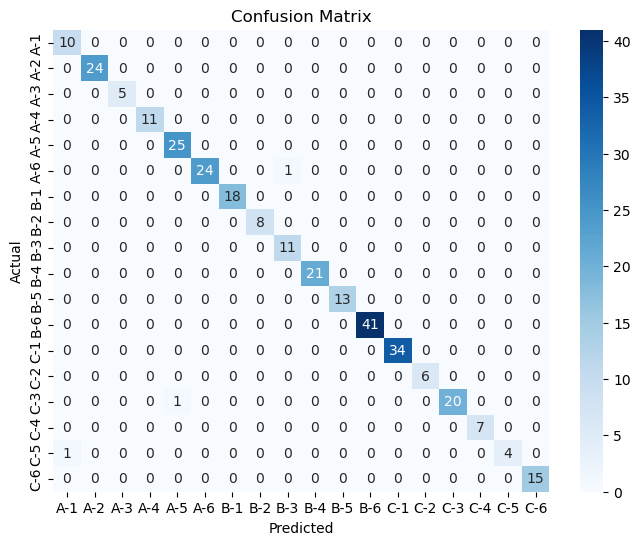

In [22]:
cm = confusion_matrix(y_test, y_pred2)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

## Exporting the Model

Here, we export the model using pickle. We will then be able to use to deploy the model locally as a flask application.

In [23]:
import pickle

# Save the model
with open('storage_prediction_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

### Neural Network (Unused)

Note: This was the initial model developed for the task, which uses a neural network. While it performs well, the random forest model is more efficient and better suited to be used for the inventory management system.

For this model, we use a neural network with softmax as the activation function at the output layer for multi-class classification. As the number of classes or different sections of storage contained in the dataset is 18, we use 18 neurons in the output layer, with one output neuron per class.

In [24]:
# def make_model():

#     model = keras.models.Sequential()
#     model.add(keras.layers.Input(shape=(12,)))
#     model.add(keras.layers.Dense(32, activation='relu'))
#     model.add(keras.layers.Dense(64, activation='relu'))
#     model.add(keras.layers.Dense(64, activation='relu'))
#     model.add(keras.layers.Dense(128, activation='relu'))
#     model.add(keras.layers.Dense(18, activation='softmax'))

#     return model

# model = make_model()


# model.summary()

Next, we compile the model. As the task performed by the model is multi-class classification, and the data is one-hot encoded, we use categorical crossentropy as the loss function. We also use adam (Adaptive Momentum Estimation) as an optimizer, allowing the learning rate to be adjusted as the model trains.

In [25]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#               metrics=['accuracy'])

We add code such that the model will store a log of its performance in a folder to be displayed and reviewed later using tensorboard.

In [26]:
# root_logdir = os.path.join(os.curdir, "tb_logs")

# def get_run_logdir():    # use a new directory for each run
# 	import time
# 	run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
# 	return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()

# tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

Finally, we begin training the model, inputting the training and validation data. The model is trained for 250 epochs, storing a record of its performance using callback.

In [27]:
# model.fit(X_train,
#           y_train,
#           validation_data = (X_test, y_test),
#           epochs=250,
#           callbacks=[tb_callback])

Now that the model has finished training, we use tensorboard to display its performance over each epoch as a graph, with both the training and validation accuracy being shown.

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs --host localhost

From the results displayed, we can see that the model training went smoothly. Both the training and validation accuracy of the model increase at a consistent pace, and there is very little variance between the training and validation accuracy, showing that the model did not experience any overfitting. 